### 1. Preparación de datos

In [14]:
# !pip install keras-tuner


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam



#Intentoss de mejorar el modelo
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # patience = número de épocas sin mejora antes de detener


# Función para cargar los datos
def load_data(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data['features'], data['labels']

# Cargar los datos
x_train, y_train = load_data('Datos_Rotulos_Trafico/Datos_Rotulos_Trafico/entrenamiento.p')
x_test, y_test = load_data('Datos_Rotulos_Trafico/Datos_Rotulos_Trafico/prueba.p')
x_val, y_val = load_data('Datos_Rotulos_Trafico/Datos_Rotulos_Trafico/validacion.p')

# Preprocesamiento: Normalización
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


### 2. Implementación de la arquitectura Le-Net

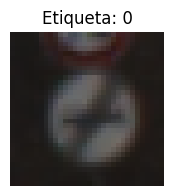

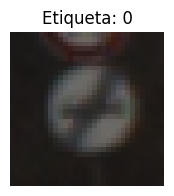

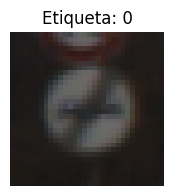

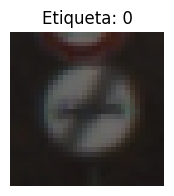

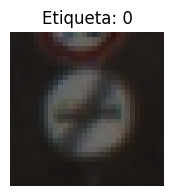

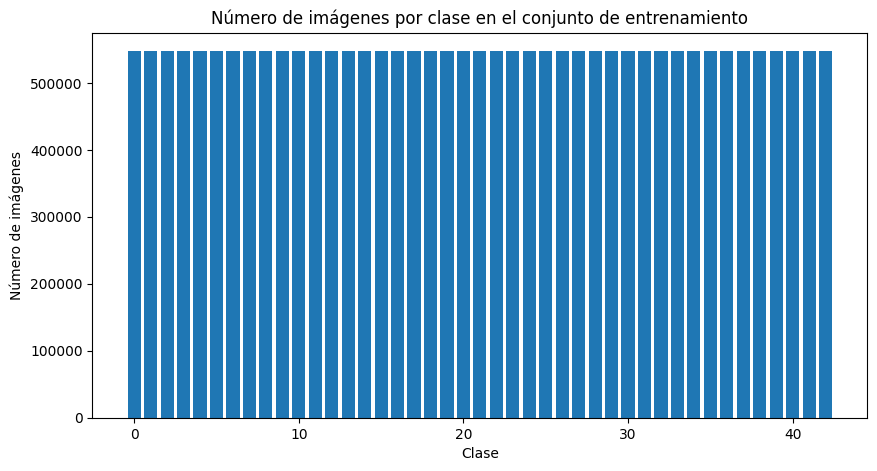

In [16]:
import matplotlib.pyplot as plt

# Muestra las primeras 5 imágenes del conjunto de entrenamiento
for i in range(5):
    plt.figure(figsize=(2,2))
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.title(f"Etiqueta: {np.argmax(y_train[i])}")
    plt.axis('off')
    plt.show()

# Contar el número de imágenes por cada clase en el conjunto de entrenamiento
class_counts = np.sum(y_train, axis=0)
plt.figure(figsize=(10,5))
plt.bar(range(43), class_counts)
plt.title("Número de imágenes por clase en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.show()

### 3. Construccion del modelo

In [10]:
def build_model(hp):
    model = models.Sequential()

    # Capa de Convolución
    model.add(layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                            kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                            activation='tanh', 
                            input_shape=(32,32,3)))
    model.add(layers.AveragePooling2D())

    # Capa de Convolución
    model.add(layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                            kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
                            activation='tanh'))
    model.add(layers.AveragePooling2D())

    model.add(layers.Flatten())

    # Capas Fully Connected
    model.add(layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16), activation='tanh'))
    model.add(layers.Dense(units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16), activation='tanh'))
    model.add(layers.Dense(43, activation='softmax'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner_search = RandomSearch(build_model,
                            objective='val_accuracy',
                            max_trials=5,
                            directory='output',
                            project_name="TrafficSignLeNet")

tuner_search.search(x_train, y_train, epochs=3, validation_data=(x_val, y_val))


Trial 5 Complete [00h 01m 38s]
val_accuracy: 0.9038548469543457

Best val_accuracy So Far: 0.9158729910850525
Total elapsed time: 00h 10m 21s
INFO:tensorflow:Oracle triggered exit


### 4. Entrenamiendo del modelo

In [11]:
# Definir hiperparámetros
batch_size = 64
epochs = 10

best_model = tuner_search.get_best_models(num_models=1)[0]
history = best_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stop])




Epoch 1/10
544/544 [==============================] - 57s 103ms/step - loss: 0.0600 - accuracy: 0.9874 - val_loss: 0.2345 - val_accuracy: 0.9331
Epoch 2/10
544/544 [==============================] - 55s 102ms/step - loss: 0.0364 - accuracy: 0.9932 - val_loss: 0.2418 - val_accuracy: 0.9304
Epoch 3/10
544/544 [==============================] - 56s 103ms/step - loss: 0.0292 - accuracy: 0.9945 - val_loss: 0.2392 - val_accuracy: 0.9272
Epoch 4/10
544/544 [==============================] - 55s 102ms/step - loss: 0.0249 - accuracy: 0.9951 - val_loss: 0.2436 - val_accuracy: 0.9340
Epoch 5/10
544/544 [==============================] - 55s 102ms/step - loss: 0.0332 - accuracy: 0.9923 - val_loss: 0.2672 - val_accuracy: 0.9252
Epoch 6/10
544/544 [==============================] - 56s 102ms/step - loss: 0.0352 - accuracy: 0.9919 - val_loss: 0.2464 - val_accuracy: 0.9295


### 4. Evaluación del modelo

In [21]:
from sklearn.metrics import classification_report

# Evaluación
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predicciones en el conjunto de prueba
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular y mostrar métricas adicionales: Precisión, Recall, F1-Score
print(classification_report(y_test, y_pred_classes))


395/395 [==============================] - 6s 15ms/step - loss: 0.3217 - accuracy: 0.9127
Test Accuracy: 91.27%
395/395 [==============================] - 6s 15ms/step
              precision    recall  f1-score   support

           0       0.93      0.67      0.78        60
           1       0.83      0.94      0.88       720
           2       0.91      0.94      0.93       750
           3       0.90      0.96      0.93       450
           4       0.95      0.88      0.91       660
           5       0.93      0.86      0.89       630
           6       0.98      0.68      0.80       150
           7       0.95      0.88      0.91       450
           8       0.85      0.93      0.89       450
           9       0.95      0.99      0.97       480
          10       0.93      0.97      0.95       660
          11       0.97      0.91      0.94       420
          12       0.99      0.95      0.97       690
          13       0.99      0.97      0.98       720
          14       0.

### 5. Visualización

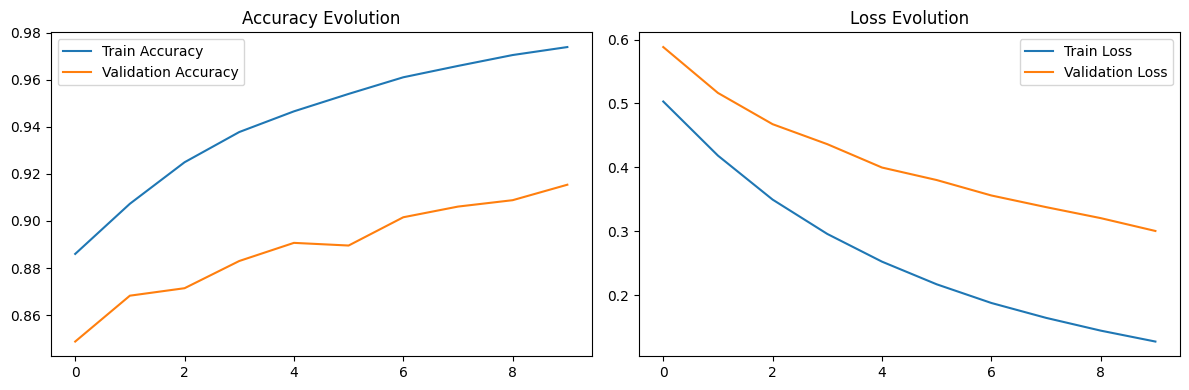

In [ ]:
# Función para visualizar la precisión y la pérdida durante el entrenamiento
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')

    plt.tight_layout()
    plt.show()

plot_history(history)
